In [1]:
import os
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

In [2]:
# IBL data (16 Sessions, July 8 batch)
# feature indices
lab_offset = 1
session_offset = 5
xyz_offset = 9
max_ptp_offset = 12
wf_width_offset = 13
left_dlc_offset = 14
right_dlc_offset = 28
stimOnOff_offset = 42
contrast_offset = 43
goCue_offset = 45
choice_offset = 46
reward_offset = 49
wheel_offset = 51
pLeft_offset = 52
lick_offset = 53
acronym_offset = 54

In [3]:
# Load data
data = {}
j = 1
directory = '/Users/ksaniee/Downloads/original_feature_list_Sebastian' #location of original_feature_list_Sebastian
for filename in os.listdir(directory):
    if 'output' in filename:
        session = filename[filename.find('_')+1:]
        data['output_%d'%j] = np.load(directory+'/'+'output_'+session)
        data['feature_%d'%j] = np.load(directory+'/'+'feature_'+session)
        j+=1
    

In [4]:
for filename in os.listdir(directory):
    if 'output' in filename:
        session = filename[filename.find('_')+1:]
        file = np.load(directory+'/'+'output_'+session)
        print('session %s: length %d'% (filename[filename.find('_')+1:filename.find('.')],file.shape[1]) )

session dac3a4c1-b666-4de0-87e8-8c514483cacf: length 432
session 746d1902-fa59-4cab-b0aa-013be36060d5: length 575
session 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b: length 694
session ecb5520d-1358-434c-95ec-93687ecd1396: length 426
session 6f09ba7e-e3ce-44b0-932b-c003fb44fb89: length 326
session f312aaec-3b6f-44b3-86b4-3a0c119c0438: length 553
session ee40aece-cffd-4edb-a4b6-155f158c666a: length 966
session 56b57c38-2699-4091-90a8-aba35103155e: length 517
session c4432264-e1ae-446f-8a07-6280abade813: length 778
session 54238fd6-d2d0-4408-b1a9-d19d24fd29ce: length 541
session e535fb62-e245-4a48-b119-88ce62a6fe67: length 342
session 3638d102-e8b6-4230-8742-e548cd87a949: length 435
session d0ea3148-948d-4817-94f8-dcaf2342bbbe: length 441
session db4df448-e449-4a6f-a0e7-288711e7a75a: length 312
session d23a44ef-1402-4ed7-97f5-47e9a7a504d9: length 329
session dda5fc59-f09a-4256-9fb5-66c67667a466: length 704


In [5]:
# Reshape all clusters to single dimension
for j in range(1,17):
    data['output_'+str(j)]=data['output_'+str(j)].transpose((1,0,2)).reshape((-1,15*44))

In [6]:
# Decision data
for j in range(1,17):
    data['decision_'+str(j)]=data['feature_'+str(j)][:,:,:,46:49].sum(2)[0,:,:]

In [7]:
# One-hot encode no choice
for j in range(1,17):
    data['decision_'+str(j)]=np.apply_along_axis(lambda x: [0.,1.,0.] if sum(x)==0 else x,1,data['decision_'+str(j)])

In [8]:
# Normalize firing rates to clusters
for s in range(1,17):
    firing_rate = data['output_'+str(s)]
    for k in range(15):
        firing_rate[:,k*44:44*(k+1)] = (firing_rate[:,k*44:44*(k+1)]-firing_rate[:,k*44:44*(k+1)].mean())/firing_rate[:,k*44:44*(k+1)].std()
    data['output_'+str(s)] = firing_rate



In [9]:
# percent of L/R/'no choices' per session
for s in range(1,17):
    print('session %d  L: %f,R: %f,no: %f'%(s,
        (data['decision_%d'%s].sum(0)[0]/data['decision_%d'%s].shape[0]),
         (data['decision_%d'%s].sum(0)[2]/data['decision_%d'%s].shape[0]),
        (data['decision_%d'%s].sum(0)[1]/data['decision_%d'%s].shape[0])))

session 1  L: 0.590278,R: 0.409722,no: 0.000000
session 2  L: 0.613913,R: 0.386087,no: 0.000000
session 3  L: 0.299712,R: 0.700288,no: 0.000000
session 4  L: 0.476526,R: 0.523474,no: 0.000000
session 5  L: 0.334356,R: 0.665644,no: 0.000000
session 6  L: 0.490054,R: 0.509946,no: 0.000000
session 7  L: 0.422360,R: 0.577640,no: 0.000000
session 8  L: 0.442940,R: 0.557060,no: 0.000000
session 9  L: 0.411311,R: 0.588689,no: 0.000000
session 10  L: 0.497227,R: 0.502773,no: 0.000000
session 11  L: 0.473684,R: 0.526316,no: 0.000000
session 12  L: 0.581609,R: 0.418391,no: 0.000000
session 13  L: 0.632653,R: 0.367347,no: 0.000000
session 14  L: 0.403846,R: 0.596154,no: 0.000000
session 15  L: 0.772036,R: 0.227964,no: 0.000000
session 16  L: 0.383523,R: 0.616477,no: 0.000000


In [10]:
# delete middle column of choice vector (since they are all 0)
for j in range(1,17):
    data['decision_'+str(j)]=data['decision_'+str(j)][:,[0,2]]

In [11]:
# prior model accuracy
maxp_accs = []
for s in range(1,17):
    maxp=data['feature_%s'%s][10,:,:,52:53].max(axis=1)
    maxp=np.floor(2*maxp)
    target=data['decision_%s'%s].argmax(axis=1)
    num_trials=target.shape[0]
    test_idxs = np.arange((int(num_trials*0.8)//50)*50,5*(num_trials//5))
    
    maxp_accs.append(np.mean(maxp[test_idxs,:]==target[test_idxs]))

maxp_accs

[0.5115976331360946,
 0.523328,
 0.5704081632653061,
 0.508096,
 0.8133333333333334,
 0.5354666666666666,
 0.49996755002704163,
 0.5150850661625709,
 0.5562448979591836,
 0.4972448979591837,
 0.5037037037037037,
 0.5153909465020576,
 0.5207407407407407,
 0.5188429752066116,
 0.7799111111111111,
 0.6443555555555556]

In [12]:
# DATA LOADER

def loaders(session,train_pct):
    
    decision = data['decision_'+str(session)]
    firing_rate = data['output_'+str(session)]
    
    num_trials = decision.shape[0]
    
    train_idxs = np.arange(0,(int(num_trials*train_pct)//50)*50)
    test_idxs = np.arange((int(num_trials*train_pct)//50)*50,5*(num_trials//5))

    train_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[train_idxs]), 
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[train_idxs])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50)
    test_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[test_idxs]),
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[test_idxs])

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)
    return train_loader,test_loader

In [13]:
# Load ALL DATA (for downstream session in zero-shot experiments)

def load_all(session):
    
    decision = data['decision_'+str(session)]
    firing_rate = data['output_'+str(session)]
    
    num_trials = decision.shape[0]
    
    idxs = np.arange(0,5*(num_trials//5))

    all_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[idxs]), 
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[idxs])

    all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=TEST_BATCH_SIZE)

    return all_loader

In [14]:
# train/test ensembling accuracy methods
def train_accuracy(net,CLASSES,train_loader):
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    num_trials = len(train_loader.dataset)
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Component accuracies:')
    print([num for index, num in enumerate(corrects) if index<TEST_SAMPLES])
    print('Posterior Mean Train Accuracy: {}/{}'.format(corrects[-1], num_trials))
    print('Ensemble Train Accuracy: {}/{}'.format(correct, num_trials))
    return (corrects[-1]/np.float(num_trials), correct/np.float(num_trials))

In [15]:
def test_accuracy(net,CLASSES,test_loader):
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    num_trials=len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False) #outputs of each sample
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Component accuracies:')
    print([num for index, num in enumerate(corrects) if index<TEST_SAMPLES])
    print('Posterior Mean Test Accuracy: {}/{}'.format(corrects[-1], num_trials))
    print('Ensemble Test Accuracy: {}/{}'.format(correct, num_trials))
    return (corrects[-1]/np.float(num_trials), correct/np.float(num_trials))

In [16]:
# load a session
TEST_BATCH_SIZE = 5
train_loader,test_loader=loaders(5,0.9)

In [17]:
# BNN

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

BATCH_SIZE = 50
TEST_BATCH_SIZE = 5


TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 2
TRAIN_EPOCHS = 20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2*math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu)**2)/(2*self.sigma**2)).sum()

class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi*prob1 + (1-self.pi)*prob2)).sum()
    
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight params
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias params
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0
        
    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0
        return F.linear(input, weight, bias)
    
    
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(30*258, 1000)
        self.l2 = BayesianLinear(1000, 40)
        self.l3 = BayesianLinear(40, 2)
    
    def forward(self, x, sample=False):
        x = x.view(-1, self.l1.in_features)
        #print(x.size())
        x = F.tanh(self.l1(x, sample))
        #print(x.size())
        x = F.tanh(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    #changed CLASSES to self.l3.out_features to allow for different class sizes when switching sources
    def sample_elbo(self, input, target, batch_idx, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, self.l3.out_features).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        #loss = (log_variational_posterior - log_prior)*(2**(NUM_BATCHES-batch_idx))/(2**NUM_BATCHES-1) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

    
def write_weight_histograms(net, epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(net, epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)
    
    
    
def train(net, optimizer, epoch, train_loader):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(net, epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target,batch_idx)
        loss.backward()
        optimizer.step()
        write_loss_scalars(net, epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(net, epoch+1)
    
    
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'






False


In [18]:
# train on a session
fnet = BayesianNetwork()
fnet.l1 = BayesianLinear(44*15,10)
fnet.l2 = BayesianLinear(10,10)
fnet.l3 = BayesianLinear(10,2)
fnet.to(DEVICE)
optimizer = optim.Adam(fnet.parameters())
for epoch in range(20):
    train(fnet, optimizer, epoch,train_loader)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 5/5 [00:00<00:00, 84.17it/s]


In [19]:
# test accuracy on a session
test_accuracy(fnet,2,test_loader)[1]

Component accuracies:
[63, 61, 63, 63, 63, 64, 61, 60, 61, 59]
Posterior Mean Test Accuracy: 62/75
Ensemble Test Accuracy: 62/75


0.8266666666666667

In [ ]:
%%capture
# training regime: 20 epochs (pre)training, 9 epochs (post)training (warm up transferred models)
# 160 epochs training (tracking test accuracy every epoch)


accs_with4 = np.zeros((16,16,160))
accs_without4 = np.zeros((16,160))

#With transfer
for s1 in np.arange(1,17):
    for s2 in np.arange(1,17):
        # (pre)train on source s1
        train_loader,test_loader=loaders(s1,train_pct=0.8)
        fnet = BayesianNetwork()
        fnet.l1 = BayesianLinear(44*15,10)
        fnet.l2 = BayesianLinear(10,10)
        fnet.l3 = BayesianLinear(10,2)
        fnet.to(DEVICE)
        optimizer = optim.Adam(fnet.parameters())
        for epoch in range(20):
            train(fnet, optimizer, epoch, train_loader)
            
        # transfer to s2
        num_ftrs = fnet.l3.in_features
        fnet.l3 = BayesianLinear(num_ftrs, 3)
        fnet = fnet.to(DEVICE)
        train_loader,test_loader=loaders(s2,train_pct=0.8)
        optimizer = optim.Adam(fnet.parameters())
        
        # warm up transferred model
        for _ in range(9):
            train(fnet, optimizer, 1, train_loader)

        # track every epoch 160 repeats
        for t in range(160):
            train(fnet, optimizer, 1, train_loader)
            accs_with4[s1-1,s2-1,t]=test_accuracy(fnet,3,test_loader)[1]
        

#Without
for s in np.arange(1,17):
    train_loader,test_loader=loaders(s,train_pct=0.8)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(44*15,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,2)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(20):
        train(fnet, optimizer, epoch, train_loader)
        
    # 9 epochs training to compare to warm transferred model
    for _ in range(9):
        train(fnet, optimizer, 1, train_loader)
        
    # track every epoch 160 repeats
    for t in range(160):
        train(fnet, optimizer, 1, train_loader)
        accs_without4[s-1,t]=test_accuracy(fnet,2,test_loader)[1]

In [21]:
%%capture
# Baseline: Logistic Regression

# Train on downstream (80%)

from sklearn.linear_model import LogisticRegression

accs_without_L = np.zeros(16)

for s in np.arange(1,17):
    # train LR on 80% s2 trials
    decision = data['decision_'+str(s)]
    firing_rate = data['output_'+str(s)]

    num_trials = decision.shape[0]

    train_idxs = np.arange(0,(int(num_trials*0.8)//50)*50)
    test_idxs = np.arange((int(num_trials*0.8)//50)*50,5*(num_trials//5))

    lr = LogisticRegression(C=1e5)
    lr.fit(firing_rate[train_idxs],decision.argmax(1)[train_idxs])

    preds = lr.predict(firing_rate[test_idxs])

    accs_without_L[s-1]=np.mean(preds==decision.argmax(1)[test_idxs])



Text(0, 0.5, 'test accuracy (choice)')

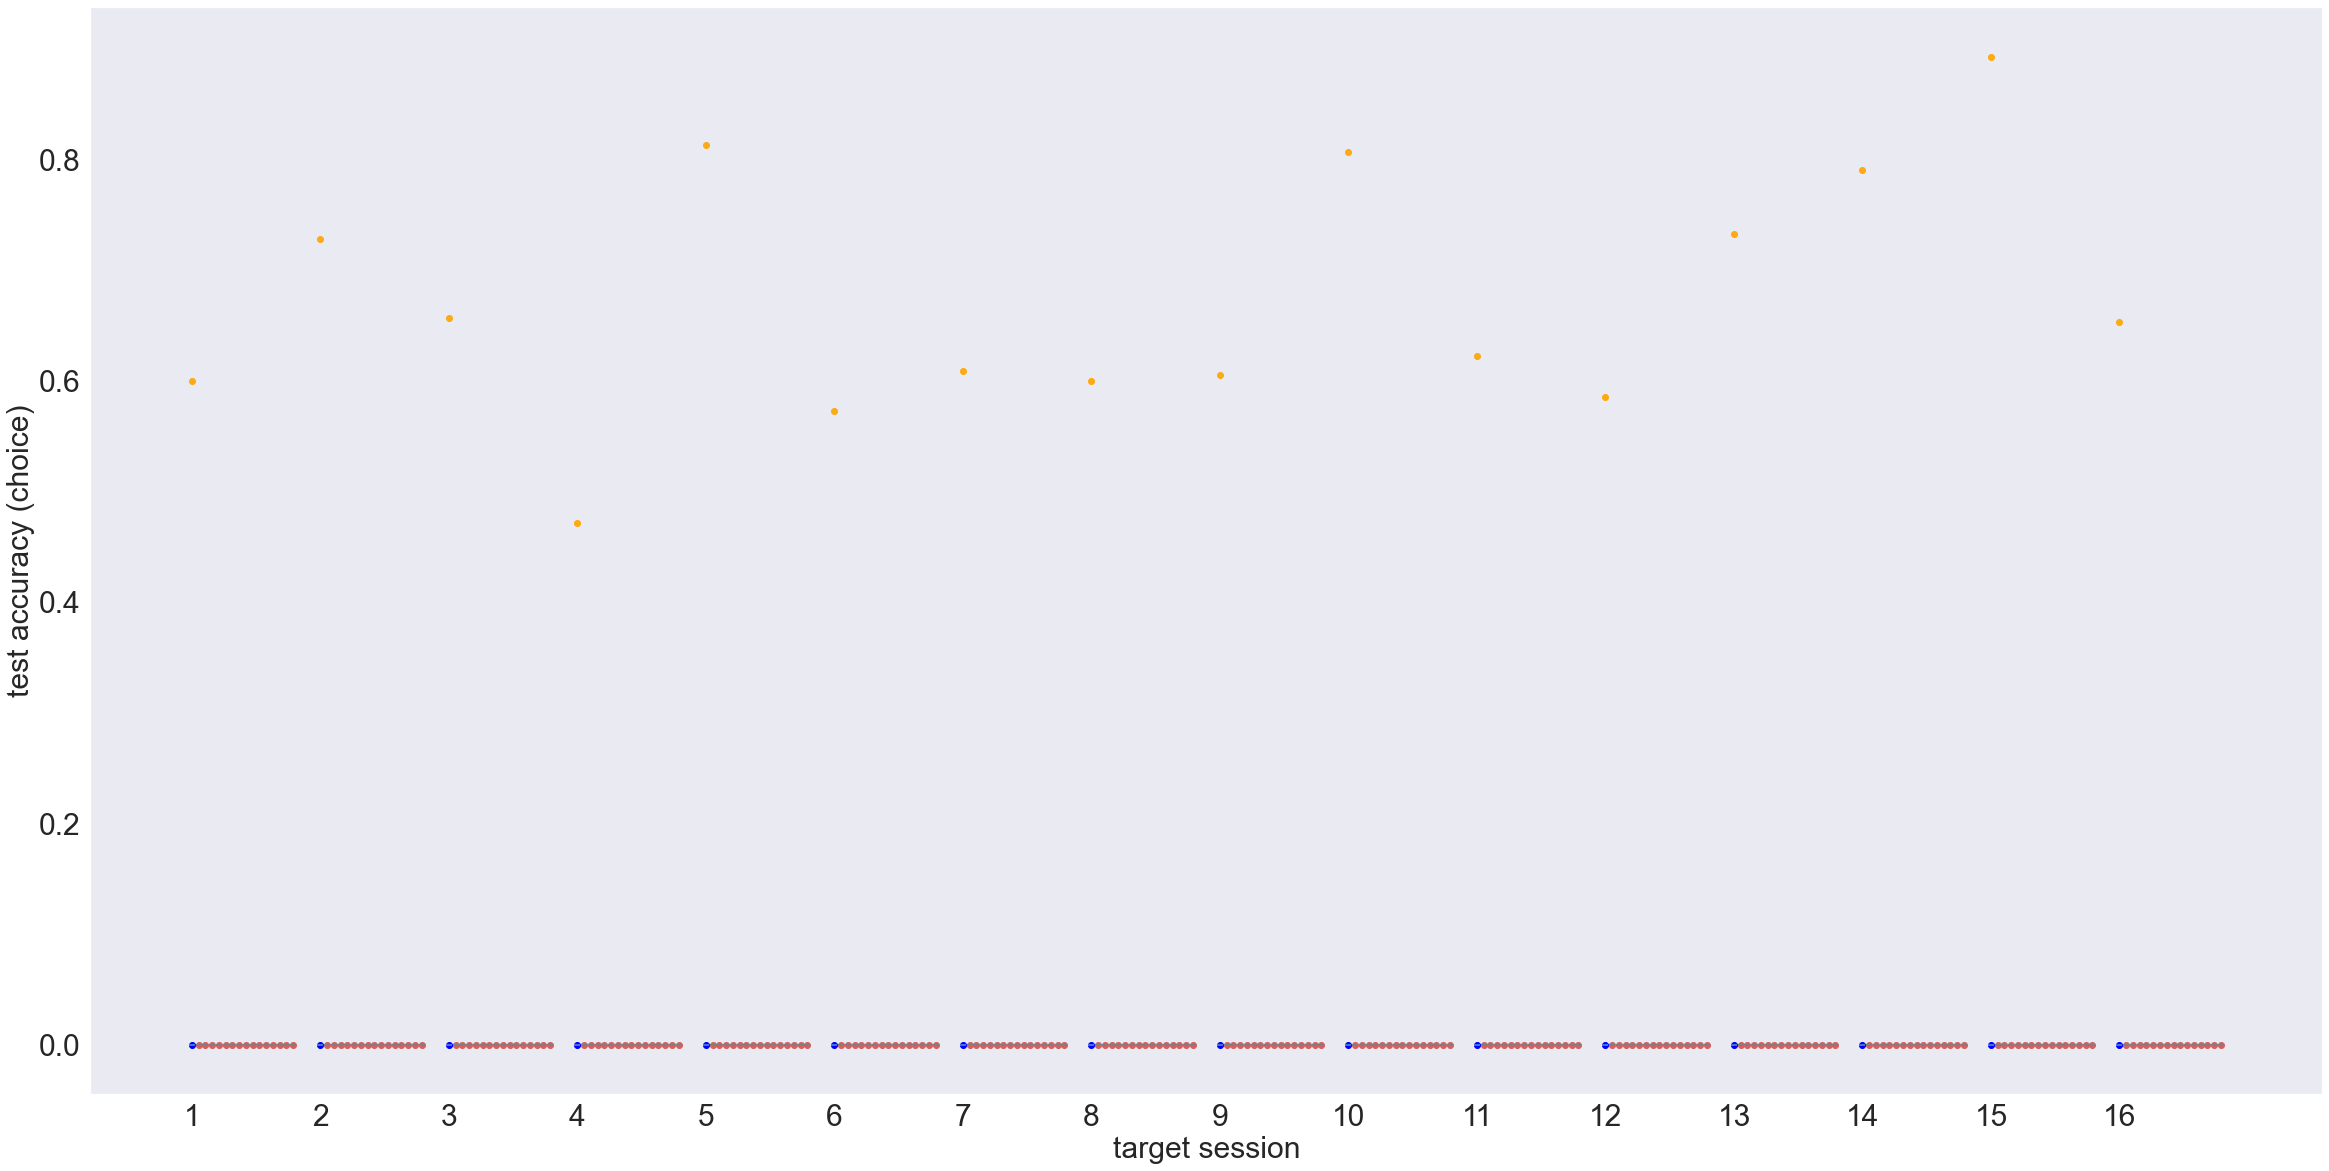

In [22]:
# Plot one dot for intra-session training, transferred models, LR. 160 epochs
# 50pct intervals around median for BMLPs

plt.figure(figsize=(40,20))

for s2 in range(1,17):
    plt.scatter(s2+np.linspace(0,1,20)[1:16],[accs_with4[s-1,s2-1,:].max() for s in range(1,17) if s!=s2],
                c='r',label='with transfer')
    
    plt.vlines(s2+np.linspace(0,1,20)[1:16],
               [np.quantile(accs_with4[s-1,s2-1,:],0.25) for s in range(1,17) if s!=s2],
               [np.quantile(accs_with4[s-1,s2-1,:],0.75) for s in range(1,17) if s!=s2],color='gray',alpha=0.5)
    
    plt.scatter(s2+np.linspace(0,1,20)[1:16],[np.quantile(accs_with4[s-1,s2-1,:],0.25) for s in range(1,17) if s!=s2],
               color='gray',marker='_')
    
    plt.scatter(s2+np.linspace(0,1,20)[1:16],[np.quantile(accs_with4[s-1,s2-1,:],0.75) for s in range(1,17) if s!=s2],
               color='gray',marker='_')
    
    for s in range(1,17):
        if s!=s2 and accs_without4[s2-1,:].max()<accs_with4[s-1,s2-1,:].max():
            ind = [u for u in range(1,17) if u!=s2].index(s)
            plt.vlines(s2+np.linspace(0,1,20)[1:16][ind], accs_without4[s2-1,:].max(),
                      accs_with4[s-1,s2-1,:].max(),color='green')
    
    
for s in range(1,17):
    plt.scatter(s,accs_without4[s-1,:].max(),c='blue',label='without transfer')
    
    plt.vlines(s,
               np.quantile(accs_without4[s-1,:],0.25),
               np.quantile(accs_without4[s-1,:],0.75),color='b',alpha=0.5)
    
    plt.scatter(s,np.quantile(accs_without4[s-1,:],0.25),
               color='b',marker='_')
    
    plt.scatter(s,np.quantile(accs_without4[s-1,:],0.75),
               color='b',marker='_')
    
    #LR
    plt.scatter(s,accs_without_L[s-1],c='orange',label='LR',alpha=0.9)

plt.xticks(np.arange(1,17),size=30)[1];  plt.yticks(size=30)
plt.xlabel('target session',size=30); plt.ylabel('test accuracy (choice)',size=30)

In [ ]:
# diagonal plot, transferred over intra-session

fig=plt.figure(figsize=(10,7))
plt.scatter([accs_without4[s-1,:].max() for s in range(1,17)],
        [accs_with4[:,s-1,:].max() for s in range(1,17)],marker='x')
plt.plot(np.linspace(0,1,50),np.linspace(0,1,50),c='black')
plt.xlabel('test accuracy, no transfer')
plt.ylabel('test accuracy, transfer')
plt.title('best performance on 16 target sessions (test on last 20%)')

In [ ]:
# Switching BMLP on behavioral signal

In [25]:
# Switching BMLP

class BayesianNetwork_withPrior(nn.Module):
    def __init__(self):
        super().__init__()
        self.s0_l1 = BayesianLinear(44*15, 10)
        self.s0_l2 = BayesianLinear(10, 10)
        self.s0_l3 = BayesianLinear(10, 2)
        
        self.s1_l1 = BayesianLinear(44*15, 10)
        self.s1_l2 = BayesianLinear(10, 10)
        self.s1_l3 = BayesianLinear(10, 2)
    
    def forward(self, x, sample=False):
        s = 1 if x[0,-1]>0.5 else 0
        if s==0:
            x = x[:,:-1].view(-1, self.s0_l1.in_features) #remove last entry (pLeft)
            #print(x.size())
            x = F.tanh(self.s0_l1(x, sample))
            #print(x.size())
            x = F.tanh(self.s0_l2(x, sample))
            x = F.log_softmax(self.s0_l3(x, sample), dim=1)
        else:
            x = x[:,:-1].view(-1, self.s1_l1.in_features)
            #print(x.size())
            x = F.tanh(self.s1_l1(x, sample))
            #print(x.size())
            x = F.tanh(self.s1_l2(x, sample))
            x = F.log_softmax(self.s1_l3(x, sample), dim=1)            
        return x
    
    def log_prior(self,input):
        s = 1 if input[0,-1]>0.5 else 0
        if s==0: return self.s0_l1.log_prior + self.s0_l2.log_prior + self.s0_l3.log_prior
        else: return self.s1_l1.log_prior + self.s1_l2.log_prior + self.s1_l3.log_prior
    
    def log_variational_posterior(self,input):
        s = 1 if input[0,-1]>0.5 else 0
        if s==0: 
            return self.s0_l1.log_variational_posterior + self.s0_l2.log_variational_posterior + self.s0_l3.log_variational_posterior
        else:
            return self.s1_l1.log_variational_posterior + self.s1_l2.log_variational_posterior + self.s1_l3.log_variational_posterior
        
        
    #changed CLASSES to self.l3.out_features to allow for different class sizes when switching sources
    def sample_elbo(self, input, target, batch_idx, samples=SAMPLES):
        outputs = torch.zeros(samples, 1, self.s0_l3.out_features).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior(input)
            log_variational_posteriors[i] = self.log_variational_posterior(input)
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        #loss = (log_variational_posterior - log_prior)*(2**(NUM_BATCHES-batch_idx))/(2**NUM_BATCHES-1) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [26]:
# Train method for switching model
def train_withPrior(net, optimizer, epoch, train_loader):
    net.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target,batch_idx)
        loss.backward(retain_graph=True)
        optimizer.step()

In [29]:
# test accuracy for use with switching model (same as above method, with test batch size 1)
def test_accuracy_withPrior(net,CLASSES,test_loader):
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    num_trials=len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, 1, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False) #outputs of each sample
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Component accuracies:')
    print([num for index, num in enumerate(corrects) if index<TEST_SAMPLES])
    print('Posterior Mean Test Accuracy: {}/{}'.format(corrects[-1], num_trials))
    print('Ensemble Test Accuracy: {}/{}'.format(correct, num_trials))
    return (corrects[-1]/np.float(num_trials), correct/np.float(num_trials))

In [27]:
# DATA LOADER for switching model: load firing rates with Bayes decision (s=1_pLeft>1/2) 

def load_one(session,train_pct):
    
    decision = data['decision_'+str(session)]
    firing_rate = data['output_'+str(session)]
    maxp=data['feature_%s'%session][10,:,:,52:53].max(axis=1)
    
    firing_rate = np.hstack((firing_rate,maxp)) # firing rates with Bayes decision
    
    num_trials = decision.shape[0]
    
    train_idxs = np.arange(0,(int(num_trials*train_pct)//50)*50)
    test_idxs = np.arange((int(num_trials*train_pct)//50)*50,5*(num_trials//5))

    train_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[train_idxs]), 
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[train_idxs])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    test_dataset = torch.utils.data.TensorDataset(
        torch.Tensor(firing_rate[test_idxs]),
        torch.Tensor(decision).type(torch.LongTensor).argmax(dim=1)[test_idxs])

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    return train_loader,test_loader

In [ ]:
%%capture
# train on 2 sessions, compare switching to no switch/intra-session model

#Session 5
accs_switch5 = np.zeros((20,100))
accs_noswitch5 = np.zeros((20,100))
s=5
for t in range(20):
    #switch
    train_one_loader,test_one_loader = load_one(s,0.8)
    pnet = BayesianNetwork_withPrior()
    pnet.to(DEVICE)
    optimizer = optim.Adam(pnet.parameters())
    for epoch in range(100):
        train_withPrior(pnet, optimizer, epoch, train_one_loader)
        accs_switch5[t,epoch] = test_accuracy_withPrior(pnet,2,test_one_loader)[1]

    # no switch
    train_loader,test_loader=loaders(s,0.8)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(44*15,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,2)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(100):
        train(fnet, optimizer, epoch,train_loader)
        accs_noswitch5[t,epoch] = test_accuracy(fnet,2,test_loader)[1]
        
#Session 15
accs_switch15 = np.zeros((20,100))
accs_noswitch15 = np.zeros((20,100))
s=15
for t in range(20):
    #switch
    train_one_loader,test_one_loader = load_one(s,0.8)
    pnet = BayesianNetwork_withPrior()
    pnet.to(DEVICE)
    optimizer = optim.Adam(pnet.parameters())
    for epoch in range(100):
        train_withPrior(pnet, optimizer, epoch, train_one_loader)
        accs_switch15[t,epoch] = test_accuracy_withPrior(pnet,2,test_one_loader)[1]

    # no switch
    train_loader,test_loader=loaders(s,0.8)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(44*15,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,2)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(100):
        train(fnet, optimizer, epoch,train_loader)
        accs_noswitch15[t,epoch] = test_accuracy(fnet,2,test_loader)[1]

In [ ]:
%%capture
# train on 2 sessions, compare switching to no switch/intra-session model

#Session 4
accs_switch4 = np.zeros((20,100))
accs_noswitch4 = np.zeros((20,100))
s=4
for t in range(20):
    #switch
    train_one_loader,test_one_loader = load_one(s,0.8)
    pnet = BayesianNetwork_withPrior()
    pnet.to(DEVICE)
    optimizer = optim.Adam(pnet.parameters())
    for epoch in range(100):
        train_withPrior(pnet, optimizer, epoch, train_one_loader)
        accs_switch4[t,epoch] = test_accuracy_withPrior(pnet,2,test_one_loader)[1]

    # no switch
    train_loader,test_loader=loaders(s,0.8)
    fnet = BayesianNetwork()
    fnet.l1 = BayesianLinear(44*15,10)
    fnet.l2 = BayesianLinear(10,10)
    fnet.l3 = BayesianLinear(10,2)
    fnet.to(DEVICE)
    optimizer = optim.Adam(fnet.parameters())
    for epoch in range(100):
        train(fnet, optimizer, epoch,train_loader)
        accs_noswitch4[t,epoch] = test_accuracy(fnet,2,test_loader)[1]

Text(0, 0.5, 'test accuracy, switching')

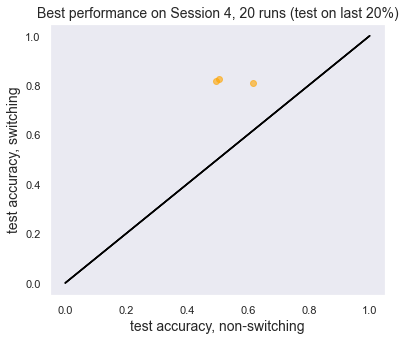

In [34]:
plt.figure(figsize=(6,5))
for t in range(3):
    plt.scatter(accs_noswitch4[t,:].max(),accs_switch4[t,:].max(),color='orange',alpha=0.6)
    plt.plot(np.linspace(0,1,50),np.linspace(0,1,50),c='black')
plt.title('Best performance on Session 4, 20 runs (test on last 20%)',size=14)
plt.xlabel('test accuracy, non-switching',size=14);plt.ylabel('test accuracy, switching',size=14)